# Text-Summarization-Encoder-Decoder-Attention

## Import Modules

In [1]:
from attention import AttentionLayer

In [2]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup

from tokenizers import Tokenizer as BertTokenizer  # Rename to avoid confusion

# Load the BERT tokenizer
Tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## EDA

In [3]:
data = pd.read_csv("reviews.csv", nrows = 45000)

In [4]:
data.sample(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
16386,16387,B007TJGZ54,AEGVTVTTVZZYN,Sally Gillman,2,2,5,1319846400,Great Coffee!!,Excellent coffee for someone who wants a mediu...
22753,22754,B000E1HUXU,A2IYH8F97UCZ6G,"kalnvnxta ""kq lover""",4,4,5,1166572800,SOOOOOOO DELISH AND *VEGAN*,these are VERY GOOD for making chocolate chip ...
29782,29783,B000GFYRIK,A2YA1BS8206IBC,Layne,0,0,5,1330732800,Hard to find the Cinnamon Stick Tea,I LOVE this tea. It can be hard to find when ...
39129,39130,B0012HAUTQ,A2NE5Q3WHISGON,damato,0,0,5,1341273600,best crushed tomatoes!,I will only use Muir glen for crushed tomatoes...
37856,37857,B0058RNX22,A3CDJXK10KNPFM,Timothy Haas,0,0,5,1323475200,Fresh,"Found the candy to be fresh and as always, tas..."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      45000 non-null  int64 
 1   ProductId               45000 non-null  object
 2   UserId                  45000 non-null  object
 3   ProfileName             44997 non-null  object
 4   HelpfulnessNumerator    45000 non-null  int64 
 5   HelpfulnessDenominator  45000 non-null  int64 
 6   Score                   45000 non-null  int64 
 7   Time                    45000 non-null  int64 
 8   Summary                 44998 non-null  object
 9   Text                    45000 non-null  object
dtypes: int64(5), object(5)
memory usage: 3.4+ MB


In [6]:
# I see some missing data, give that it very less we will simply drop them
data.dropna(axis=0,inplace=True)

In [7]:
# Remove duplicate as well
data.drop_duplicates(subset=['Text'],inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42023 entries, 0 to 44943
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      42023 non-null  int64 
 1   ProductId               42023 non-null  object
 2   UserId                  42023 non-null  object
 3   ProfileName             42023 non-null  object
 4   HelpfulnessNumerator    42023 non-null  int64 
 5   HelpfulnessDenominator  42023 non-null  int64 
 6   Score                   42023 non-null  int64 
 7   Time                    42023 non-null  int64 
 8   Summary                 42023 non-null  object
 9   Text                    42023 non-null  object
dtypes: int64(5), object(5)
memory usage: 3.5+ MB


## Pre-Processing

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
import emoji
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
import ast
from nltk.corpus import stopwords
import string
import re

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))

# Load contractions and slang dictionaries
try:
    with open('contractions.txt', 'r') as file:
        content = file.read()
    content = '{' + content.strip().rstrip(',') + '}'
    contractions_dict = ast.literal_eval(content)

    slang_dict = {}
    with open('slang.txt', 'r') as file:
        for line in file:
            parts = line.strip().split('=')
            if len(parts) == 2:
                slang_dict[parts[0].strip().upper()] = parts[1].strip()  # Ensure keys are uppercase
except FileNotFoundError as e:
    print(f"Error: {e}")

# Create an instance of the PorterStemmer
ps = PorterStemmer()

def preprocess_text(df, text_column):
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Apply all preprocessing steps
    df[text_column] = df[text_column].str.lower().apply(encode_emojis)
    df[text_column] = df[text_column].apply(remove_misencoded_chars)
    df[text_column] = df[text_column].apply(contra_conv)
    df[text_column] = df[text_column].apply(basic_preprocess)
    df[text_column] = df[text_column].apply(remove_punc)
    df[text_column] = df[text_column].apply(chat_conv)
    df[text_column] = df[text_column].apply(remove_stopwords)

    return df

def remove_punc(text):
    """Remove punctuation from text while preserving hashtags."""
    if isinstance(text, str):
        punct = string.punctuation
        return text.translate(str.maketrans('', '', punct))
    return text

def encode_emojis(text):
    """Convert emojis to text representation."""
    if isinstance(text, str):
        emojis = re.findall(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF'
                            r'\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF'
                            r'\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF]', text)
        for emoji_ in emojis:
            text = text.replace(emoji_, emoji.demojize(emoji_))
        return text
    return text

def remove_misencoded_chars(text):
    """Remove misencoded characters from text."""
    if isinstance(text, str):
        cleaned_text = text.replace('ð', '')
        cleaned_text = re.sub(r'[^\x00-\x7F]+', '', cleaned_text)
        return cleaned_text
    return text

def contra_conv(text):
    """Convert contractions to their expanded form."""
    if isinstance(text, str):
        new_text = [contractions_dict.get(w, w) for w in text.split()]
        return " ".join(new_text)
    return text

def basic_preprocess(text):
    """Perform basic text preprocessing."""
    text = text.replace('%', ' percent').replace('$', ' dollar ').replace('₹', ' rupee ').replace('€', ' euro ').replace('@', ' at ')
    text = text.replace(',000,000,000 ', 'b ').replace(',000,000 ', 'm ').replace(',000 ', 'k ')
    text = re.sub(r'([0-9]+)000000000', r'\1b', text)
    text = re.sub(r'([0-9]+)000000', r'\1m', text)
    text = re.sub(r'([0-9]+)000', r'\1k', text)

    # Removing HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    return text

def chat_conv(text):
    """Convert chat/slang words to their standard form."""
    if isinstance(text, str):
        new_text = [slang_dict.get(w.upper(), w) for w in text.split()]
        return " ".join(new_text)
    return text

def remove_stopwords(text):
    """Remove stopwords from text."""
    if isinstance(text, str):
        words = [word for word in text.split() if word.lower() not in stop_words]
        return " ".join(words)
    return text

In [ ]:
# pre-processing
data = preprocess_text(data, "Text")
data = preprocess_text(data, "Summary")

In [14]:
sample_text = data['Text'].head(1).str.cat(sep=' ')
print(sample_text)

bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better


In [39]:
sample_summary = data['Summary'].head(1).str.cat(sep=' ')
print(sample_summary)

awesome terrible waste money quick service good long best salt around rich j wyzykoski heinz ranch dressing great ehh palatepleasing pepper flavor reednikki71 yahoocom stephens gourmet candycane cocoa dry packet food pouches strangely yummy addictive dog actually liked flavor yummm deliciously sour super tasty happens healthy dog live without medium bodied smooth keeps busy little help superb good product poor quanitity nutella favorite vita coco beverages one dented cans


## Feature-Engineering

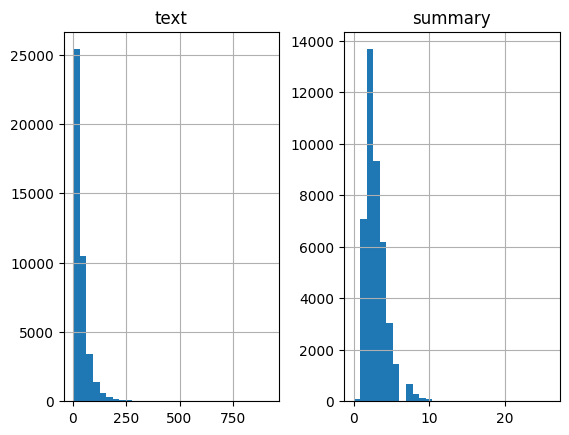

Text - Max length: 920, Min length: 4, Most frequent length: 13
Summary - Max length: 26, Min length: 0, Most frequent length: 2


In [16]:
# analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text.
# This will help us fix the maximum length of the sequence {Then do truncate/padding}

import matplotlib.pyplot as plt
import pandas as pd

# Calculate text and summary word counts directly
text_word_count = [len(i.split()) for i in data['Text']]
summary_word_count = [len(i.split()) for i in data['Summary']]

# Create a DataFrame for easy plotting and analysis
length_df = pd.DataFrame({'text': text_word_count, 'summary': summary_word_count})

# Plot the histograms
length_df.hist(bins=30)
plt.show()

# Get min, max, and most frequent word lengths
max_text_length = max(text_word_count)
min_text_length = min(text_word_count)
most_frequent_text_length = length_df['text'].mode()[0]

max_summary_length = max(summary_word_count)
min_summary_length = min(summary_word_count)
most_frequent_summary_length = length_df['summary'].mode()[0]

print(f"Text - Max length: {max_text_length}, Min length: {min_text_length}, Most frequent length: {most_frequent_text_length}")
print(f"Summary - Max length: {max_summary_length}, Min length: {min_summary_length}, Most frequent length: {most_frequent_summary_length}")

In [17]:
# fix the max_len_size for both text and summart as we
# input to model is of fixed size length!
max_len_text = 80
max_len_summary = 7

In [18]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['Text'],data['Summary'],test_size=0.1,random_state=69,shuffle=True)

In [19]:
# Function to encode sentences with padding
def encode_with_padding(sentences, max_length):
    encoded_sentences = []
    for sentence in sentences:
        # Encode the sentence
        encoded = Tokenizer.encode(sentence).ids  # Get token IDs

        # Truncate if longer than max_length
        if len(encoded) > max_length:
            encoded = encoded[:max_length]

        # Pad to max_length
        padding_length = max_length - len(encoded)
        if padding_length > 0:
            encoded = encoded + [0] * padding_length  # Pad with 0s

        encoded_sentences.append(encoded)

    return encoded_sentences

# Encode training and validation datasets
x_tr = encode_with_padding(x_tr, 80)
x_val = encode_with_padding(x_val, 80)
y_tr = encode_with_padding(y_tr, 10)
y_val = encode_with_padding(y_val, 10)

In [20]:
x_voc_size = len(Tokenizer.get_vocab())
y_voc_size = len(Tokenizer.get_vocab())

## Model-Architecture

In [36]:
from keras import backend as K
K.clear_session()

latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs)

# LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Decoder
decoder_inputs = Input(shape=(max_len_summary,))
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = Dense(y_voc_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 80)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 80, 256)        │      7,813,632 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 80, 256),      │        525,312 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 7)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 80, 256),      │        525,312 │ lstm[0][0]             │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 7, 256)         │      7,813,632 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 80, 256),      │        525,312 │ lstm_1[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, 7, 256),       │        525,312 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ [(None, 7, 256),       │        131,328 │ lstm_2[0][0],          │
│ (AttentionLayer)          │ (None, 7, 80)]         │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, 7, 512)         │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 7, 30522)       │     15,657,786 │ concat_layer[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,517,626 (127.86 MB)

 Trainable params: 33,517,626 (127.86 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Convert to NumPy arrays
x_tr = np.array(x_tr)
y_tr = np.array(y_tr)
x_val = np.array(x_val)
y_val = np.array(y_val)

# Convert NumPy arrays to TensorFlow tensors
x_tr = tf.convert_to_tensor(x_tr)
y_tr = tf.convert_to_tensor(y_tr)
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)

## Model-Training

In [23]:
# Add gradient clipping to prevent exploding gradients
optimizer = tf.keras.optimizers.RMSprop(clipnorm=1.0)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Initialize EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Fit the model
history = model.fit(
    [x_tr, y_tr[:, :-1]],  # Training data inputs
    tf.reshape(y_tr, (y_tr.shape[0], y_tr.shape[1], 1))[:, 1:],  # Reshaping target data for training
    epochs=50,
    callbacks=[es],
    batch_size=32,
    validation_data=(
        [x_val, y_val[:, :-1]],  # Validation data inputs
        tf.reshape(y_val, (y_val.shape[0], y_val.shape[1], 1))[:, 1:]  # Reshaping validation target data
    )
)

Epoch 1/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 160s 125ms/step - accuracy: 0.5913 - loss: 3.5214 - val_accuracy: 0.6234 - val_loss: 3.0247
Epoch 2/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 146s 124ms/step - accuracy: 0.6225 - loss: 3.0048 - val_accuracy: 0.6285 - val_loss: 2.9104
Epoch 3/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 146s 123ms/step - accuracy: 0.6266 - loss: 2.8842 - val_accuracy: 0.6310 - val_loss: 2.8223
Epoch 4/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 145s 123ms/step - accuracy: 0.6300 - loss: 2.7894 - val_accuracy: 0.6284 - val_loss: 2.7935
Epoch 5/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 203s 124ms/step - accuracy: 0.6317 - loss: 2.7456 - val_accuracy: 0.6370 - val_loss: 2.7412
Epoch 6/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 200s 123ms/step - accuracy: 0.6358 - loss: 2.6985 - val_accuracy: 0.6391 - val_loss: 2.6925
Epoch 7/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 146s 124ms/step - accuracy: 0.6407 - loss: 2.6255 - val_accuracy: 0.6391 - val_loss: 2.6832
Epoch 8/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 201s 123ms/step - ac

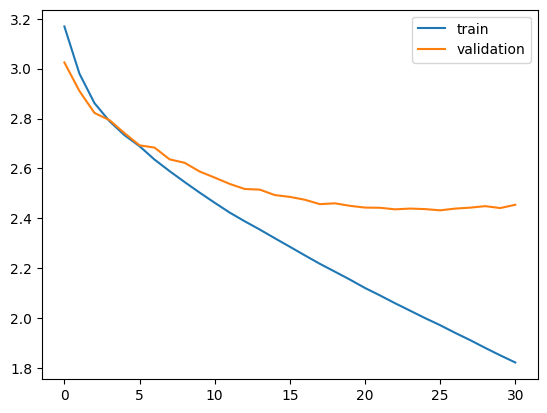

In [24]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

## Model-Inferencing

In [25]:
target_word_index = Tokenizer.get_vocab()
reverse_target_word_index = {v: k for k, v in target_word_index.items()}
reverse_source_word_index = {v: k for k, v in target_word_index.items()}

In [26]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [27]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [28]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

## Results

In [34]:
# Define a function to clean up the output
def clean_text(text):
    # Replace tokens with empty strings
    text = text.replace("[CLS]", "").replace("[SEP]", "").replace("[PAD]", "").strip()
    return text

# Loop through the first 10 validation samples
for i in range(10):
    # Convert the input sequence back to text
    review_text = seq2text(x_val[i].numpy())  # Convert tensor to NumPy array
    original_summary = seq2summary(y_val[i].numpy())  # Convert tensor to NumPy array
    predicted_summary = decode_sequence(x_val[i].numpy().reshape(1, max_len_text))  # Convert tensor to NumPy array

    # Clean the summaries
    cleaned_original_summary = clean_text(original_summary)
    cleaned_predicted_summary = clean_text(predicted_summary)

    # Print the results
    print("Review:", clean_text(review_text))
    print("Original summary:", cleaned_original_summary)
    print("Predicted summary:", cleaned_predicted_summary)
    print("\n")  # Print a newline for better readability


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Review: coconut palm sugar bad substitute baking however significantly less sweet white sugar enjoyed sweet want sweet pastry may need read ##just amount using coconut palm sugar also hard make syrup melt ##s quite bit faster white sugar
Original summary: bad substitute
Predicted summary: sugar sugar


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Review: quick easy portable think tastes great favorite flavor
Original summary: delicious
Predicted summary: good


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━

In [35]:
# Loop through the first 10 Training samples
for i in range(10):
    # Convert the input sequence back to text
    review_text = seq2text(x_tr[i].numpy())  # Convert tensor to NumPy array
    original_summary = seq2summary(y_tr[i].numpy())  # Convert tensor to NumPy array
    predicted_summary = decode_sequence(x_tr[i].numpy().reshape(1, max_len_text))  # Convert tensor to NumPy array

    # Clean the summaries
    cleaned_original_summary = clean_text(original_summary)
    cleaned_predicted_summary = clean_text(predicted_summary)

    # Print the results
    print("Review:", clean_text(review_text))
    print("Original summary:", cleaned_original_summary)
    print("Predicted summary:", cleaned_predicted_summary)
    print("\n")  # Print a newline for better readability

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Review: dog trainer recommended way terri ##er mix work extra energy really slow going first could figure get food gave really easily two weeks got finally figured fantastic used take 30 seconds finish meals bowl 203 ##0 minutes keeps fully occupied valuable thing gotten dog
Original summary: works perfect terri ##er
Predicted summary: great


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Review: granddaughter ##s favorite breakfast ##al ##th ##ough likes flavors little todd ##ler meals simple easy best loved